In [1]:
%load_ext cython

In [2]:
import py_entitymatching as em

In [3]:
A = em.load_dataset('person_table_A')
B = em.load_dataset('person_table_B')

def get_str_cols(dataframe):
    return dataframe.columns[dataframe.dtypes == 'object']

In [4]:
import os
def _get_stop_words():
    stop_words_set = set()
    install_path = em.get_install_path()
    dataset_path = os.sep.join([install_path, 'utils'])
    stop_words_file = os.sep.join([dataset_path, 'stop_words.txt'])
    with open(stop_words_file, "rb") as stopwords_file:
        for stop_words in stopwords_file:
            stop_words_set.add(stop_words.rstrip())

    return stop_words_set

In [5]:
%%cython
#distutils: language=c++
from libcpp.vector cimport vector
from libcpp.string cimport string
from libcpp.map cimport map as omap
from libcpp.set cimport set as oset
from libcpp.algorithm cimport sort
from libcpp cimport bool
from libcpp.pair cimport pair
cdef extern from "string.h":
    char *strtok_r (char *inp_str, const char *delimiters, char **) nogil

# cdef extern from "string.h":
#     char *strtok_r (char *inp_str, const char *delimiters, char **)


########################################
cdef class StringContainer:
    cdef vector[string] sc
    cdef int csize(self):
        return self.sc.size()

        
    
    def size(self):
        return self.sc.size()
    def push_back(self, s):
        self.sc.push_back(s)
    def get(self, int i):
        return self.sc[i]
    
    def __getstate__(self):
        return self.sc
    def __setstate__(self, state):
        self.sc = state
########################################
cdef class TokenContainer:
    cdef vector[vector[string]] tc
    
    cdef int csize(self):
        return self.tc.size()
    
    cdef void cinit(self, int n) nogil:
#     cdef void cinit(self, int n):
        cdef int i
        for i in xrange(n):
            self.tc.push_back(vector[string]())
    cdef void cpush_back(self, vector[string] tokens):
        self.tc.push_back(tokens)

    cdef vector[string] cremove_stopwords(self,  vector[string]& svec, \
                                           omap[string, int]& stopwords) nogil:
#     cdef vector[string] cremove_stopwords(self,  vector[string]& svec, \
#                                            omap[string, int]& stopwords):

        cdef vector[string] ovec
        cdef string token
        for token in svec:
            if (stopwords.find(token) == stopwords.end()):
                ovec.push_back(token)
        return ovec

    cdef vector[string] ctokenize_wd(self, const string& inp) nogil:
#     cdef vector[string] ctokenize_wd(self, const string& inp):
        cdef char* ptr1
        cdef char* pch = strtok_r(<char*> inp.c_str(), " \t\n", &ptr1)
        cdef oset[string] tokens
        cdef vector[string] out
        cdef string s
        while pch != NULL:
            tokens.insert(string(pch))
            pch = strtok_r(NULL, " \t\n", &ptr1)
        for s in tokens:
            out.push_back(s)
        return out
        
    cdef void ctokenize(self, vector[string]& svec,  omap[string, int]& stopwords) nogil:
#     cdef void ctokenize(self, vector[string]& svec,  omap[string, int]& stopwords):        
        cdef int n = svec.size()
        cdef int i
        cdef string s
        cdef vector[string] tokens
        
        self.cinit(n)
        
        for i in xrange(n):
            s = svec[i]
            tokens = self.ctokenize_wd(s)
            tokens = self.cremove_stopwords(tokens, stopwords)
            self.tc[i] = tokens
        
    def tokenize(self, StringContainer objsc, stopwords):
        cdef omap[string, int] smap
        str2bytes = lambda x: x if isinstance(x, bytes) else x.encode('utf-8')
        if len(stopwords):
            for s in stopwords:
                smap[s] = 0
        with nogil:
            self.ctokenize(objsc.sc, smap)
    
    def get(self, int i):
        return self.tc[i]
    
    def size(self):
        return self.csize()

    def __getstate__(self):
        return self.tc
    def __setstate__(self, state):
        self.tc = state
    
 ########################################   

cdef class InvertedIndex:
    cdef omap[string, vector[int]] index
    cdef vector[int] cvalues(self, string token):
        cdef vector[int] tmp
        if self.index.find(token) != self.index.end():
            return self.index[token]
        else:
            return tmp
    
    cdef void cbuild_inv_index(self, vector[vector[string]]& token_vector):
        cdef int n = token_vector.size()
        cdef int i, j
        cdef int m
        cdef vector[string] tokens
        
        for i in xrange(n):
            tokens = token_vector[i]
            m = tokens.size()
            for j in xrange(m):
                self.index[tokens[j]].push_back(i)
            
    def build_inv_index(self, TokenContainer objtc):
        self.cbuild_inv_index(objtc.tc)
        
    def values(self, token):
        return self.cvalues(token)

    def __getstate__(self):
        return self.index
    def __setstate__(self, state):
        self.index = state
    
    
 ########################################  
cdef bool comp(const pair[int, int] l, const pair[int, int] r):
    return l.second > r.second 
cdef class Prober:
    cdef vector[int] llocs
    cdef vector[int] rlocs
    
    cdef int clsize(self):
        return self.llocs.size()
    
    cdef int crsize(self):
        return self.rlocs.size()
    
    cdef vector[int] cget_llocs(self):
        sort(self.llocs.begin(), self.llocs.end())
        return self.llocs
    cdef vector[int] cget_rlocs(self):
        return self.rlocs
        

    cdef inline vector[int] cvalues(self, omap[string, vector[int]]& index, string token) nogil:
#     cdef inline vector[int] cvalues(self, omap[string, vector[int]]& index, string token):
        cdef vector[int] tmp
        if index.find(token) != index.end():
            return index[token]
        else:
            return tmp
    
    
    cdef void cprobe(self, vector[vector[string]]& token_vector, \
                     vector[int] ids,
                     omap[string, vector[int]]& index, int yparam) nogil:
#     cdef void cprobe(self, vector[vector[string]]& token_vector, \
#                      vector[int] ids,
#                      omap[string, vector[int]]& index, int yparam):
        
        cdef int m, n
        cdef int i, j, k
        cdef vector[string] tokens
        cdef oset[int] lset, rset
        cdef vector[int] candidates
        cdef omap[int, int] cand_overlap
        cdef pair[int, int] entry
        cdef vector[pair[int, int]] tmp
        cdef int rid
        cdef int mx = 0
        n = token_vector.size()
        for i in xrange(n):
            tokens = token_vector[i]
            rid = ids[i]

            for j in xrange(tokens.size()):
                candidates = self.cvalues(index, tokens[j])
#                 with nogil:
                for cand in candidates:
                    cand_overlap[cand] += 1
            if cand_overlap.size():
                rset.insert(i)
            for entry in cand_overlap:
                tmp.push_back(entry)
            sort(tmp.begin(), tmp.end(), comp)
            k = 0
            for entry in tmp:
                lset.insert(entry.first)
                k += 1
                if k == yparam:
                    break
            cand_overlap.clear()
            tmp.clear()
        for i in lset:
            self.llocs.push_back(i)
        for i in rset:
            self.rlocs.push_back(i)
    
    def probe(self, TokenContainer objtc, ids, InvertedIndex index, int yparam):
        cdef vector[int] cids
        cids = ids
        with nogil:
            self.cprobe(objtc.tc, cids, index.index, yparam)
    
    def get_lids(self):
        return self.cget_llocs()
    def get_rids(self):
        return self.cget_rlocs()

    def __getstate__(self):
        return (self.llocs, self.rlocs)
    def __setstate__(self, state):
        llocs, rlocs = state
        self.llocs = llocs
        self.rlocs = rlocs
    
                
                
                    
            
            
        
    
    

In [7]:
from dask import delayed, threaded

In [8]:
import string
# def preprocess_table(dataframe):
#     str_cols = get_str_cols(dataframe)
#     projected_df = dataframe[str_cols]
#     concat_strings = []

#     str_container_obj = StringContainer()
#     for row in projected_df.itertuples(name=None):
#         idx = row[0]
#         joined_row = ' '.join(row[1:])
#         joined_row = joined_row.translate(None, string.punctuation)
#         concat_strings.append(joined_row.lower())
#         str_container_obj.push_back(str2bytes(joined_row.lower()))
        
#     return str_container_obj
@delayed
def preprocess_table(dataframe):
    str_cols = get_str_cols(dataframe)
    proj_df = dataframe[str_cols]
    concat_strings = []
    str_container = StringContainer()
    str2bytes = lambda x: x if isinstance(x, bytes) else x.encode('utf-8')
    for row in proj_df.itertuples(name=None):
        idx = row[0]
        column_values = row[1:]
        strs = [column_value.strip() for column_value in column_values if not pd.isnull(column_value)]
        joined_row = ' '.join(strs)
        joined_row = joined_row.translate(None, string.punctuation)
        concat_strings.append(joined_row.lower())
        str_container.push_back(str2bytes(joined_row.lower()))
    return str_container

@delayed
def tokenize_strings(concat_strings, stopwords):
    n = concat_strings.size()
    tok_container_obj = TokenContainer()
    tok_container_obj.tokenize(concat_strings, stopwords)
    return tok_container_obj
@delayed
def build_inv_index(tokens):
    inv_obj = InvertedIndex()
    inv_obj.build_inv_index(tokens)
    return inv_obj
@delayed
def probe(tokens, ids, invindex, y):
    probe_obj = Prober()
    probe_obj.probe(tokens, ids, invindex, y)
    return probe_obj
@delayed
def postprocess(l):
    return l[0]
        

In [9]:
import pandas as pd

C = pd.read_csv('songs.csv')
D = pd.read_csv('tracks.csv')

/Users/pradap/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
len(C), len(D)

(961593, 734485)

In [11]:
stopwords = list(_get_stop_words())
# stopwords.extend(['the', 'my', 'i', 'andre', 'from', 'a', 'of', 'the', 'version', 'love', 'live', 'la', 'mix', 'album', \
#                   'dont', 'remix', 'feat'])
stopwords.extend(['the', 'my', 'i', 'andre', 'from', 'a', 'of', 'the', 'version', 'love', 'live', 'la', 'mix', 'album', \
                  'dont'])

In [12]:
import numpy as np
lconcat_strings = preprocess_table(C)
ltokens = tokenize_strings(lconcat_strings, stopwords)
D1 = D.sample(10000, replace=False)
inv_index = build_inv_index(ltokens)
list_dfs = np.array_split(D1, 4)
list_ids = np.array_split(range(10000), 4)
res_list = []
for k in range(4):
    rconcat_strings = preprocess_table(list_dfs[k])
    # %time stopwords=['san', 'st', 'francisco']
    rtokens = tokenize_strings(rconcat_strings, stopwords)
    ids = list_ids[k]
    probe_res = probe(rtokens, ids, inv_index, 1)
    res_list.append(probe_res)
res = postprocess(res_list)






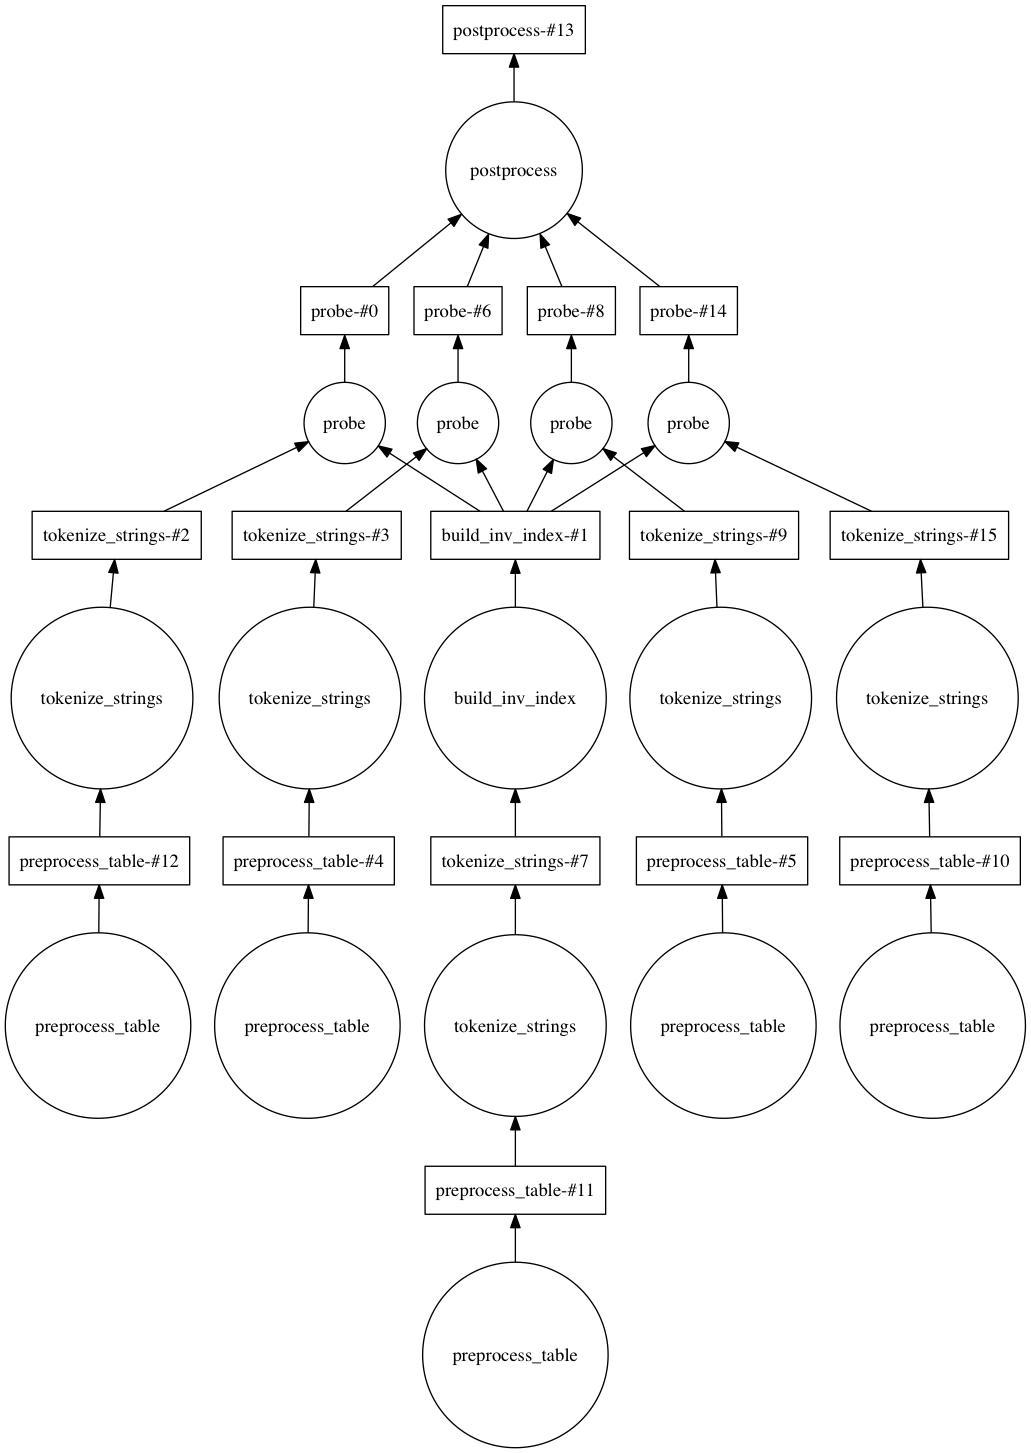

In [13]:
res.visualize()

In [14]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler

In [15]:
from dask import multiprocessing

In [16]:
from dask.distributed import Client

In [17]:
client = Client()

In [18]:
# res = inv_index.compute()

In [19]:
# C.head()

In [ ]:
# with Profiler() as prof, ResourceProfiler(dt=0.15) as rprof, CacheProfiler() as cprof:
%time xx = res.compute(get=client.get, optimize_graph=True)

In [21]:
prof.visualize()

Figure(id='e03736c9-8f62-4dca-be6d-4bc3b0120aa2', ...)

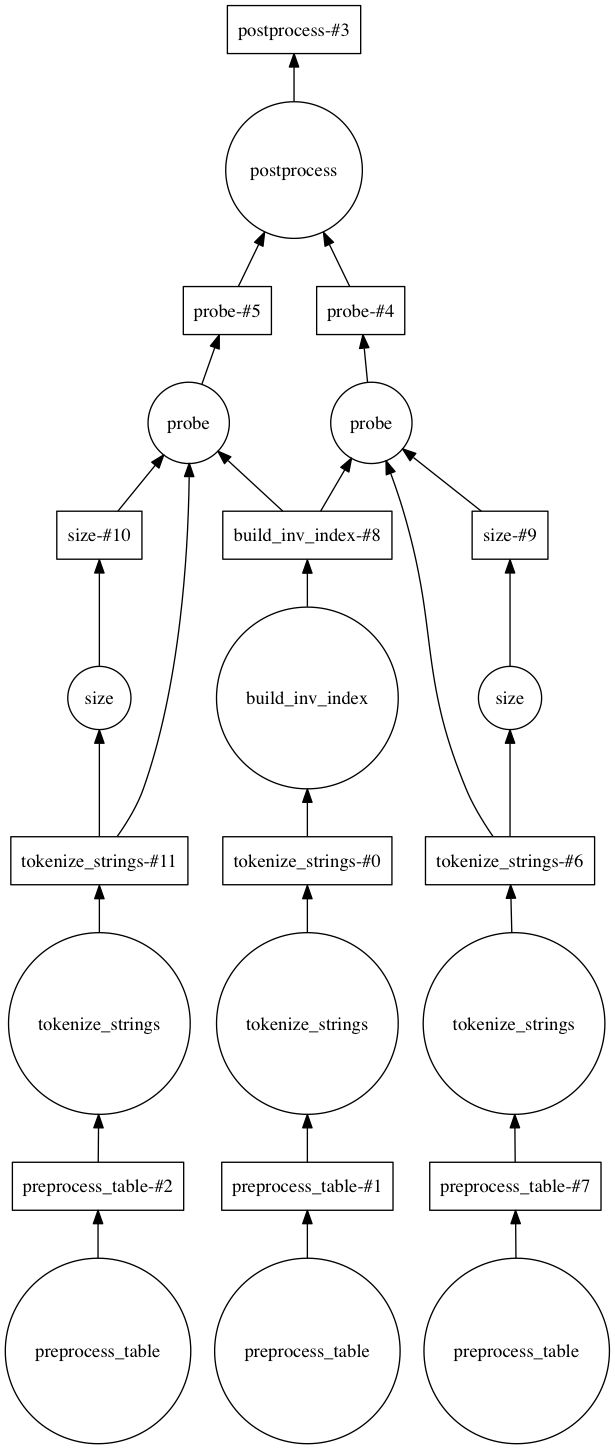

In [102]:
res.visualize()

In [115]:
rprof.visualize()

Figure(id='f3950c7e-8b82-4e3d-8990-c3d644b80710', ...)

In [99]:
help(res.compute)

Help on method compute in module dask.base:

compute(self, **kwargs) method of dask.delayed.Delayed instance
    Compute this dask collection
    
    This turns a lazy Dask collection into its in-memory equivalent.
    For example a Dask.array turns into a NumPy array and a Dask.dataframe
    turns into a Pandas dataframe.  The entire dataset must fit into memory
    before calling this operation.
    
    Parameters
    ----------
    get : callable, optional
        A scheduler ``get`` function to use. If not provided, the default
        is to check the global settings first, and then fall back to
        the collection defaults.
    optimize_graph : bool, optional
        If True [default], the graph is optimized before computation.
        Otherwise the graph is run as is. This can be useful for debugging.
    kwargs
        Extra keywords to forward to the scheduler ``get`` function.



In [74]:
with ProgressBar():
    xx = res.compute(get=threaded.get, optimize_graph=False)

[########################################] | 100% Completed | 17.3s


In [128]:
res = xx.get_rids()

In [22]:
rids = (probe_res.get_rids())

In [25]:
r = rids.compute()

In [77]:
len(res)

998

In [76]:
D1.iloc[res].head()

,id,title,year,episode,song,artists
537865,537865,Melodramma,1934.0,NaN,Violino tzigano,cesare a. bixio+bruno cherubini
331499,331499,A Bigger Splash,2015.0,NaN,FALSTAFF,giuseppe verdi+berliner philarmoniker
448629,448629,Gammat Jammat,1987.0,NaN,Aaley Me Aaley,anuradha paudwal+arun paudwal
540183,540183,Mickey Donald Goofy: The Three Musketeers,2004.0,NaN,Pop Goes the Weasle,NaN
621821,621821,Something Better Somewhere Else,2010.0,NaN,Orions Belt,justin planasch


In [73]:
lconcat_strings.get(0)
ltokens.get(0)
inv_index.values('francisco')

[0, 1, 2, 3, 4]